In [7]:
import sys
sys.path.append('..')

import method.io
input_ids = ['101315', '170042', '160132', '155808', '144838',
             '141658', '134001', '111641', '135701', '151206']
broken_electrodes = [1, 12, 16]
input_values = []
filtered_datas = []

for input_id in input_ids:
    fi = 'input/' + input_id + '.txt'
    fd = 'data/' + input_id + '.txt'
    input_values.append(method.io.load_input(fi))

    # Load data
    raw_data = method.io.load(fd)
    filtered_data = method.io.mask(raw_data, x=broken_electrodes)
    filtered_datas.append(filtered_data)
    n_readout, n_stimuli = filtered_data.shape

In [140]:
import numpy as np
X_jstim = []
y_jstim = []
j_stim = 2
for i in range(len(input_ids)):
    for j in range(n_readout):
        if (j + 1) not in broken_electrodes + [j_stim + 1]:
            X_jstim.append(np.append(j, np.log(input_values[i]+1)))  # Here j might want to input x_j
            #X_jstim.append(np.append(j, i))
            y_jstim.append(filtered_datas[i][j, j_stim])

X_jstim = np.asarray(X_jstim)
y_jstim = np.asarray(y_jstim)

In [134]:
print(X_jstim.shape, y_jstim.shape)

(120, 6) (120,)


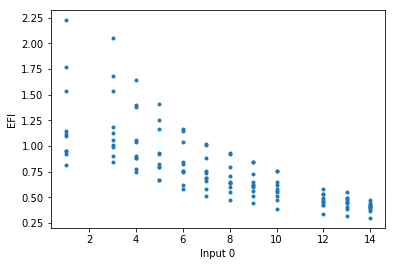

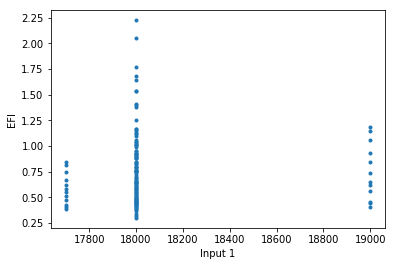

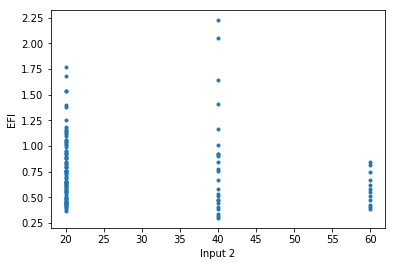

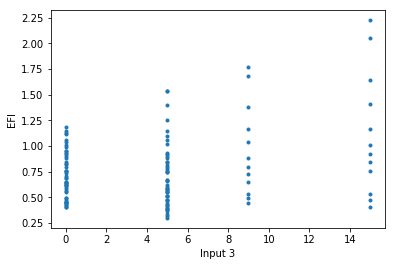

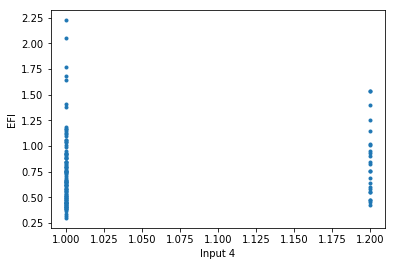

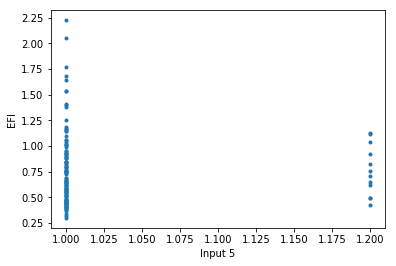

In [176]:
import matplotlib.pyplot as plt
for i in range(X_jstim.shape[1]):
    x = np.exp(X_jstim[:,i]) - 1 if i != 0 else X_jstim[:,i]
    plt.plot(x, y_jstim, '.')
    plt.ylabel('EFI')
    plt.xlabel('Input ' + str(i))
    plt.show()

In [136]:
from sklearn.gaussian_process import GaussianProcessRegressor

#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
#kernel = DotProduct() + WhiteKernel()

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=1e-10,#1e-3,
                               n_restarts_optimizer=10,
                               random_state=0)
gpr.fit(X_jstim, y_jstim)
gpr.score(X_jstim, y_jstim)

/home/chon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00038713,  0.00411319]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  " state: %s" % convergence_dict)


0.9999999999999956

In [137]:
predict_k = 8
input_k_predict_x = [np.append(i, np.log(input_values[predict_k]+1)) for i in np.linspace(1, 15, 100)]
input_k_predict_y = gpr.predict(input_k_predict_x, return_std=True)

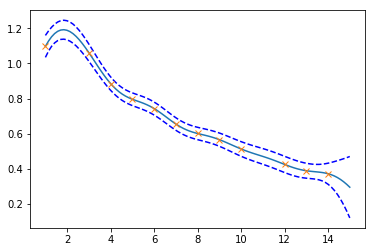

In [138]:
plt.plot(np.asarray(input_k_predict_x)[:, 0], input_k_predict_y[0], c='C0')
plt.plot(np.asarray(input_k_predict_x)[:, 0], input_k_predict_y[0] + 2 * input0_predict_y[1], 'b--')
plt.plot(np.asarray(input_k_predict_x)[:, 0], input_k_predict_y[0] - 2 * input0_predict_y[1], 'b--')
plt.plot(range(n_readout), filtered_datas[predict_k][:, j_stim], 'x', c='C1')
plt.show()

In [177]:
predict_new = [1, 5]
new_input_value = [1.85e4, 4e1, 9e0, 1, 1] #np.mean(np.asarray(input_values)[predict_new], axis=0)
print('Model to predict: ', new_input_value)
print('Data: ', input_values[predict_new[0]], input_values[predict_new[1]])
input_new_predict_x = [np.append(i, np.log(np.asarray(new_input_value)+1)) for i in np.linspace(1, 15, 100)]
input_new_predict_y = gpr.predict(input_new_predict_x, return_std=True)

Model to predict:  [18500.0, 40.0, 9.0, 1, 1]
Data:  [1.8e+04 4.0e+01 5.0e+00 1.0e+00 1.0e+00] [1.9e+04 2.0e+01 0.0e+00 1.0e+00 1.0e+00]


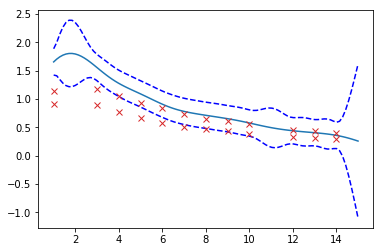

In [178]:
plt.plot(np.asarray(input_new_predict_x)[:, 0], input_new_predict_y[0], c='C0')
plt.plot(np.asarray(input_new_predict_x)[:, 0], input_new_predict_y[0] + 2 * input_new_predict_y[1], 'b--')
plt.plot(np.asarray(input_new_predict_x)[:, 0], input_new_predict_y[0] - 2 * input_new_predict_y[1], 'b--')
plt.plot(range(n_readout), filtered_datas[predict_new[0]][:, j_stim], 'x', c='C3')
plt.plot(range(n_readout), filtered_datas[predict_new[1]][:, j_stim], 'x', c='C3')
plt.show()